In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
races = pd.read_csv("raw_data/races.csv")
results = pd.read_csv("raw_data/results.csv")
drivers = pd.read_csv("raw_data/drivers.csv")
driver_standings = pd.read_csv("raw_data/driver_standings.csv")
lap_times = pd.read_csv("raw_data/lap_times.csv")
qualifying = pd.read_csv("raw_data/qualifying.csv")
pit_stops = pd.read_csv("raw_data/pit_stops.csv")
statuses = pd.read_csv("raw_data/status.csv")

In [12]:
# Get a dictionary that ties driver IDs to anmes
drivers['name'] = drivers['forename'] + " " + drivers['surname']
idToDriver = drivers.set_index('driverId')['name'].to_dict()
# Get a dictionary that converts races to years
rtoy = races.set_index('raceId')['year'].to_dict()
results['year'] = [rtoy[race] for race in results['raceId']]
rtoname = races.set_index('raceId')['name'].to_dict()
results['circuit'] = [rtoname[result] for result in results['raceId']]

# Get a dictionary that converts race and driver to constructor
yxdToCon = {}
#... and another to convert IDs to names
cIdToName = constructors.set_index("constructorId")["name"].to_dict()
for y, d, c in zip(results['year'], results['driverId'], results['constructorId']):
    yxdToCon[(y, d)] = cIdToName[c]
def getCon(y, d):
    return yxdToCon[y, d]

# Set as year column in driver standings.
driver_standings['year'] = driver_standings['raceId'].apply(lambda x: rtoy.get(x, None))

#drivers dob formatting
drivers['dob'] = pd.to_datetime(drivers['dob'], format = "%Y-%m-%d")


In [13]:
# Gets a list of the world champions.
def world_champions():
    out = pd.DataFrame(columns = ['year', 'champId', 'champName', 'age', 'nationality', 'team'])
    for year, group in driver_standings.groupby("year"):
        if (year < 2023):
            try:
                champ = int(group.loc[group['points'] == max(group['points'])]['driverId'])
            except TypeError as e:
                champ = int(group.loc[group['points'] == max(group['points'])]['driverId'].iloc[0])

            constructor = getCon(year, champ)
            personal_data = drivers[drivers.driverId == champ].iloc[0]
            age = year - personal_data['dob'].year
            nationality = personal_data['nationality']
            
            out.loc[len(out)] = [year, champ, idToDriver[champ], age, nationality, constructor]
    return out.set_index('year')
    
champs = world_champions()
champs


,champId,champName,age,nationality,team
year,,,,,
1950,642,Nino Farina,44,Italian,Alfa Romeo
1951,579,Juan Fangio,40,Argentine,Alfa Romeo
1952,647,Alberto Ascari,34,Italian,Ferrari
1953,647,Alberto Ascari,35,Italian,Ferrari
1954,579,Juan Fangio,43,Argentine,Mercedes
...,...,...,...,...,...
2018,1,Lewis Hamilton,33,British,Mercedes
2019,1,Lewis Hamilton,34,British,Mercedes
2020,1,Lewis Hamilton,35,British,Mercedes


In [14]:
def qualifying_winner(raceId):
    mask = np.logical_and(qualifying.raceId == raceId, qualifying.position == 1)
    return int(qualifying[mask]['driverId'])

def chicken_dinner(raceId):
    mask = np.logical_and(results.raceId == raceId, results.position == "1")
    return int(results[mask]['driverId'])

qual_v_race = pd.DataFrame(columns = ['raceId', 'qualifyingWinner', 'raceWinner'])
for race in qualifying['raceId'].unique():
    qual_v_race.loc[len(qual_v_race)] = [race, qualifying_winner(race), chicken_dinner(race)]

qual_v_race = qual_v_race.merge(races, how = 'left', on = 'raceId')[['raceId', 'qualifyingWinner', 'raceWinner', 'year', 'round', 'circuitId', 'name']]


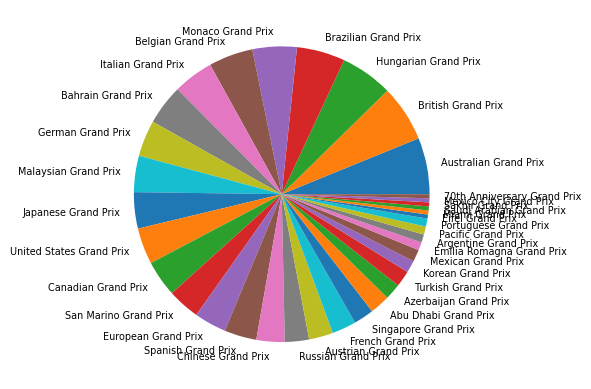

In [15]:
diffs = qual_v_race.qualifyingWinner != qual_v_race.raceWinner
pie_shares, pie_labels = qual_v_race[diffs].value_counts("name").values, qual_v_race[diffs].value_counts("name").index
plt.pie(pie_shares, labels = pie_labels, textprops={'size': 'x-small'})
plt.show()

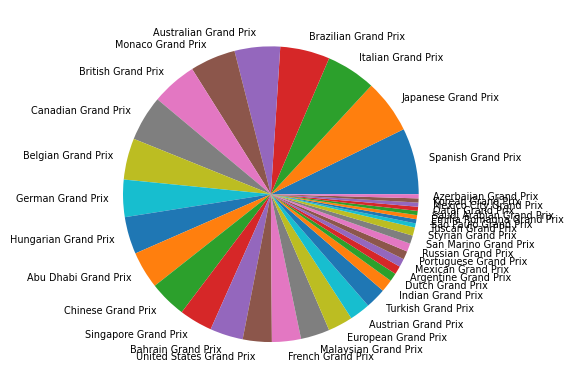

In [16]:
sames = qual_v_race.qualifyingWinner == qual_v_race.raceWinner
pie_shares, pie_labels = qual_v_race[sames].value_counts("name").values, qual_v_race[sames].value_counts("name").index
plt.pie(pie_shares, labels = pie_labels, textprops={'size': 'x-small'})
plt.show()

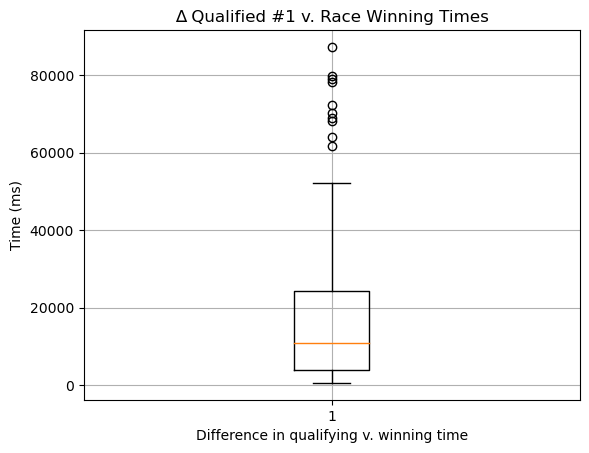

In [17]:
qvr_wins = qual_v_race.sort_values("year")
qvr_races = qvr_wins['raceId'].unique()
race_wins = {}
qvr_analysis = pd.DataFrame(columns=['raceId', 'qCrash', 'qFinish', 'rFinish', 'qPosition'])
for race in qvr_races:
    qw, rw = qvr_wins.loc[qvr_wins.raceId == race].iloc[0][['qualifyingWinner', 'raceWinner']]
    race_wins[race] = (qw, rw)
    race_results = results.loc[results['raceId'] == race]
    qw_results = race_results.loc[race_results['driverId'] == qw].iloc[0]
    rw_results = race_results.loc[race_results['driverId'] == rw].iloc[0]
    qPos = qw_results['positionOrder']
    crashed = False
    qFin = 0
    rFin = int(rw_results['milliseconds'])
    if str(qw_results['milliseconds']) == "\\N":
        crashed = True
    else:
        qFin = int(qw_results['milliseconds'])
    
    qvr_analysis.loc[len(qvr_analysis)] = [race, crashed, qFin, rFin, qPos]

qvr_mega = qual_v_race.merge(qvr_analysis, how = 'left', on = 'raceId')
subview = qvr_mega[np.logical_and(qvr_mega['qCrash'] == False, qvr_mega['qPosition'] != 1)]
plt.boxplot(subview['qFinish'] - subview['rFinish'])
plt.grid()
plt.ylabel("Time (ms)")
plt.xlabel("Difference in qualifying v. winning time")
plt.title("∆ Qualified #1 v. Race Winning Times")
plt.show()

In [19]:
idToStatus = statuses.set_index("statusId")['status'].to_dict()

status_categories = {
    1: 'Finished',
    2: 'Other',  # Disqualified
    3: 'Accident/Collision/Crash',
    4: 'Accident/Collision/Crash',  # Collision
    5: 'Technical Failure',  # Engine
    6: 'Technical Failure',  # Gearbox
    7: 'Technical Failure',  # Transmission
    8: 'Technical Failure',  # Clutch
    9: 'Technical Failure',  # Hydraulics
    10: 'Technical Failure',  # Electrical
    11: 'Other',  # +1 Lap
    12: 'Other',  # +2 Laps
    13: 'Other',  # +3 Laps
    14: 'Other',  # +4 Laps
    15: 'Other',  # +5 Laps
    16: 'Other',  # +6 Laps
    17: 'Other',  # +7 Laps
    18: 'Other',  # +8 Laps
    19: 'Other',  # +9 Laps
    20: 'Other',  # Spun off
    21: 'Technical Failure',  # Radiator
    22: 'Technical Failure',  # Suspension
    23: 'Technical Failure',  # Brakes
    24: 'Technical Failure',  # Differential
    25: 'Technical Failure',  # Overheating
    26: 'Technical Failure',  # Mechanical
    27: 'Technical Failure',  # Tyre
    28: 'Technical Failure',  # Driver Seat
    29: 'Technical Failure',  # Puncture
    30: 'Technical Failure',  # Driveshaft
    31: 'Other',  # Retired
    32: 'Technical Failure',  # Fuel pressure
    33: 'Technical Failure',  # Front wing
    34: 'Technical Failure',  # Water pressure
    35: 'Technical Failure',  # Refuelling
    36: 'Technical Failure',  # Wheel
    37: 'Technical Failure',  # Throttle
    38: 'Technical Failure',  # Steering
    39: 'Technical Failure',  # Technical
    40: 'Technical Failure',  # Electronics
    41: 'Technical Failure',  # Broken wing
    42: 'Technical Failure',  # Heat shield fire
    43: 'Technical Failure',  # Exhaust
    44: 'Technical Failure',  # Oil leak
    45: 'Other',  # +11 Laps
    46: 'Technical Failure',  # Wheel rim
    47: 'Technical Failure',  # Water leak
    48: 'Technical Failure',  # Fuel pump
    49: 'Technical Failure',  # Track rod
    50: 'Other',  # +17 Laps
    51: 'Technical Failure',  # Oil pressure
    128: 'Other',  # +42 Laps
    53: 'Other',  # +13 Laps
    54: 'Other',  # Withdrew
    55: 'Other',  # +12 Laps
    56: 'Technical Failure',  # Engine fire
    129: 'Technical Failure',  # Engine misfire
    58: 'Other',  # +26 Laps
    59: 'Technical Failure',  # Tyre puncture
    60: 'Technical Failure',  # Out of fuel
    61: 'Technical Failure',  # Wheel nut
    62: 'Other',  # Not classified
    63: 'Technical Failure',  # Pneumatics
    64: 'Technical Failure',  # Handling
    65: 'Technical Failure',  # Rear wing
    66: 'Accident/Collision/Crash',  # Fire
    67: 'Technical Failure',  # Wheel bearing
    68: 'Technical Failure',  # Physical
    69: 'Technical Failure',  # Fuel system
    70: 'Technical Failure',  # Oil line
    71: 'Technical Failure',  # Fuel rig
    72: 'Technical Failure',  # Launch control
    73: 'Accident/Collision/Crash',  # Injured
    74: 'Technical Failure',  # Fuel
    75: 'Technical Failure',  # Power loss
    76: 'Technical Failure',  # Vibrations
    77: 'Technical Failure',  # 107% Rule
    78: 'Technical Failure',  # Safety
    79: 'Technical Failure',  # Drivetrain
    80: 'Technical Failure',  # Ignition
    81: 'Other',  # Did not qualify
    82: 'Technical Failure',  # Injury
    83: 'Technical Failure',  # Chassis
    84: 'Technical Failure',  # Battery
    85: 'Technical Failure',  # Stalled
    86: 'Technical Failure',  # Halfshaft
    87: 'Technical Failure',  # Crankshaft
    88: 'Other',  # +10 Laps
    89: 'Technical Failure',  # Safety concerns
    90: 'Other',  # Not restarted
    91: 'Technical Failure',  # Alternator
    92: 'Technical Failure',  # Underweight
    93: 'Technical Failure',  # Safety belt
    94: 'Technical Failure',  # Oil pump
    95: 'Technical Failure',  # Fuel leak
    96: 'Other',  # Excluded
    97: 'Technical Failure',  # Did not prequalify
    98: 'Technical Failure',  # Injection
    99: 'Technical Failure',  # Distributor
    100: 'Other',  # Driver unwell
    101: 'Technical Failure',  # Turbo
    102: 'Technical Failure',  # CV joint
    103: 'Technical Failure',  # Water pump
    104: 'Accident/Collision/Crash',  # Fatal accident
    105: 'Technical Failure',  # Spark plugs
    106: 'Technical Failure',  # Fuel pipe
    107: 'Technical Failure',  # Eye injury
    108: 'Technical Failure',  # Oil pipe
    109: 'Technical Failure',  # Axle
    110: 'Technical Failure',  # Water pipe
    111: 'Other',  # +14 Laps
    112: 'Other',  # +15 Laps
    113: 'Other',  # +25 Laps
    114: 'Other',  # +18 Laps
    115: 'Other',  # +22 Laps
    116: 'Other',  # +16 Laps
    117: 'Other',  # +24 Laps
    118: 'Other',  # +29 Laps
    119: 'Other',  # +23 Laps
    120: 'Other',  # +21 Laps
    121: 'Technical Failure',  # Magneto
    122: 'Other',  # +44 Laps
    123: 'Other',  # +30 Laps
    124: 'Other',  # +19 Laps
    125: 'Other',  # +46 Laps
    126: 'Technical Failure',  # Supercharger
    127: 'Other',  # +20 Laps
    130: 'Accident/Collision/Crash',  # Collision damage
    131: 'Technical Failure',  # Power Unit
    132: 'Technical Failure',  # ERS
    133: 'Other',  # +49 Laps
    134: 'Other',  # +38 Laps
    135: 'Technical Failure',  # Brake duct
    136: 'Technical Failure',  # Seat
    137: 'Accident/Collision/Crash',  # Damage
    138: 'Accident/Collision/Crash',  # Debris
    139: 'Other',  # Illness
    140: 'Technical Failure',  # Undertray
    141: 'Technical Failure'  # Cooling system
}

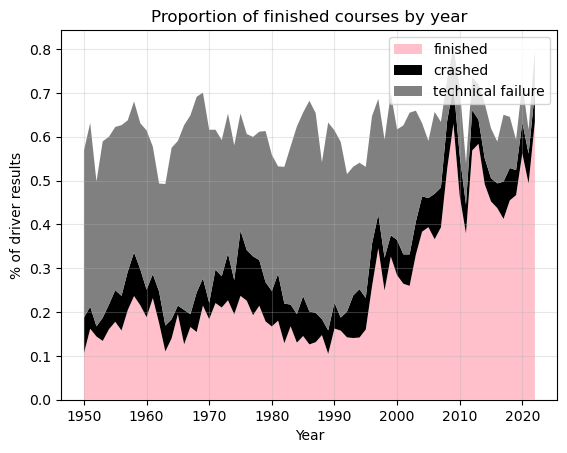

In [20]:
results['status'] = [status_categories[result] for result in results['statusId']]
percents = []
years = []
for year, group in results.groupby("year"):
    years.append(year)
    percents.append([len(group[group['status'] == 'Finished']) / len(group), len(group[group['status'] == 'Accident/Collision/Crash']) / len(group), len(group[group['status'] == 'Technical Failure']) / len(group)])
plt.stackplot(years, np.asarray(percents).T, baseline='zero', colors=['pink', 'black', 'grey'], labels=['finished', 'crashed', 'technical failure'])
plt.legend()
plt.grid(alpha=0.3)
plt.ylabel("% of driver results")
plt.xlabel("Year")
plt.title("Proportion of finished courses by year")
plt.show()

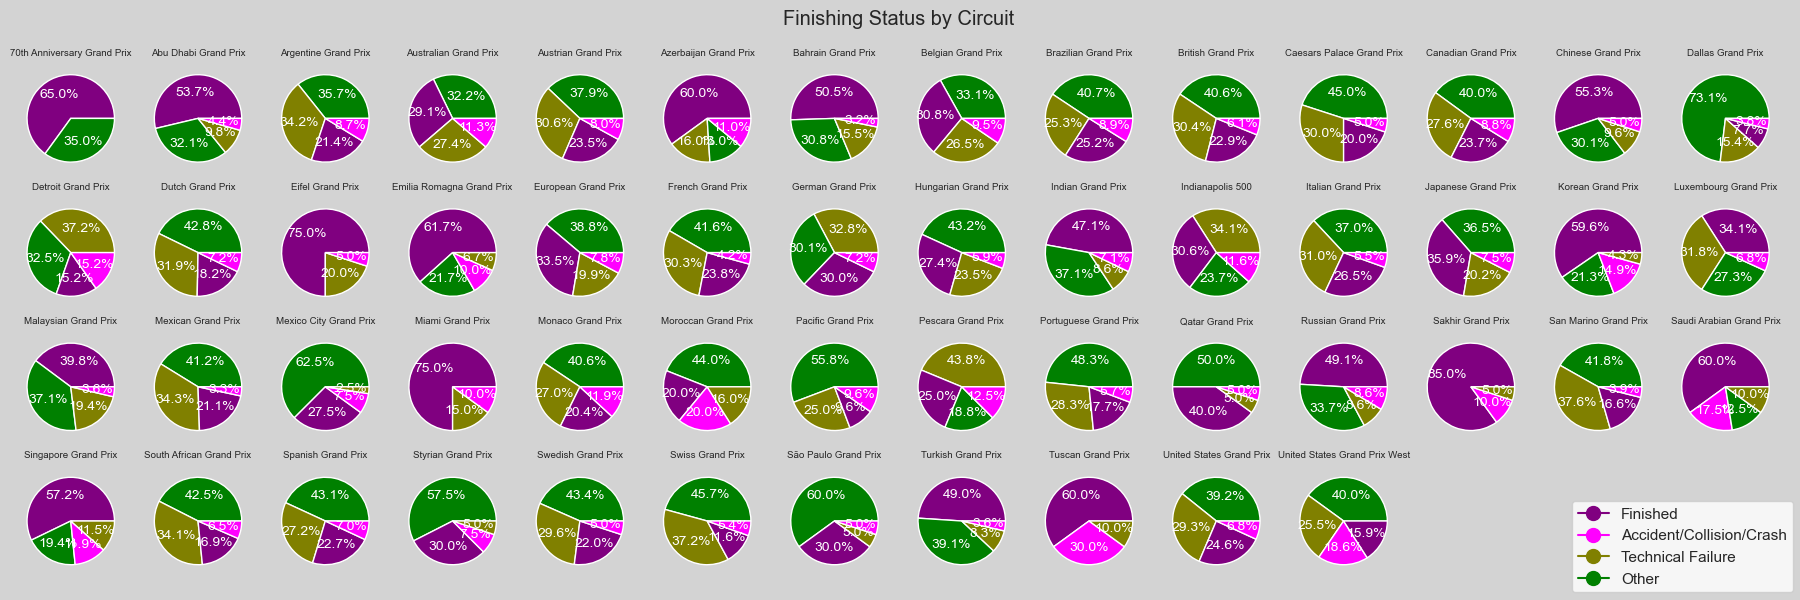

In [81]:
grouped_data = results.groupby("circuit")

# Create a 3x9 grid of pie charts
fig, axs = plt.subplots(4, 14, figsize=(18, 6), facecolor='lightgrey')

# Flatten the axs array to simplify indexing
axs = axs.flatten()


# Define a color dictionary based on status categories
status_colors = {"Finished": 'purple', "Accident/Collision/Crash": 'magenta', "Technical Failure": 'olive', "Other": "green"}

# Create a legend for the entire figure
handles = [plt.Line2D([0], [0], marker='o', color=status_colors[stati], label=stati, markersize=10) for stati in status_colors.keys()]

for i, (circuit, group) in enumerate(grouped_data):
    ax = axs[i]
    
    # Count the occurrences of each status for the current circuit
    for_pie = group["status"].value_counts()

    # Create a pie chart on the current subplot with standardized colors
    ax.pie(for_pie.values, labels=None, autopct="%1.1f%%", colors=[status_colors[status] for status in for_pie.index], textprops={'color': 'white', 'fontsize': 10})
    ax.set_title(circuit, fontsize=7)  # Adjust the title font size


# Remove empty subplots
for i in range(len(grouped_data), len(axs)):
    fig.delaxes(axs[i])

fig.legend(handles=handles, loc="lower right")
fig.suptitle("Finishing Status by Circuit")
# Adjust layout
plt.tight_layout()

# Show the pie charts
plt.show()

In [194]:
rtoy = races.set_index('raceId')['year'].to_dict()
con_standings['year'] = con_standings['raceId'].apply(lambda x: rtoy.get(x, None))
ymask = np.logical_and(con_standings['year'] >= 2014, con_standings['year'] <= 2021)
con_standings = con_standings[ymask]

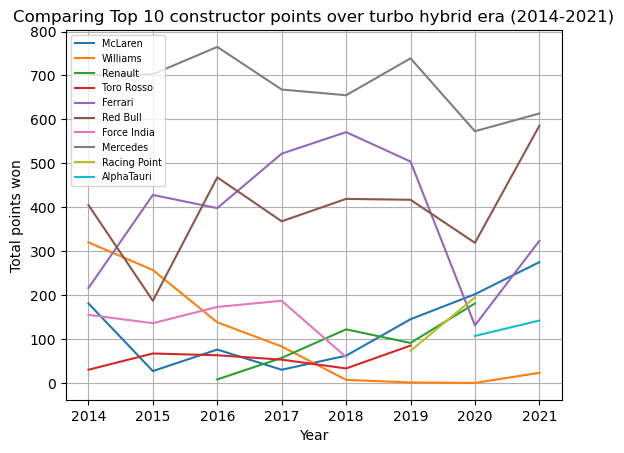

In [201]:
con_to_year = pd.DataFrame(con_standings.groupby(["constructorId", "year"])['points'].agg('max')).reset_index()
top_ten_constructors = list(con_to_year.groupby("constructorId")['points'].agg('sum').sort_values(ascending=False)[:10].index)
idToName = constructors.set_index("constructorId")["name"].to_dict()
top_ten_labels = {x: idToName[x] for x in top_ten_constructors} 
for constructor_id, group in con_to_year.groupby('constructorId'):
    if constructor_id in top_ten_labels:
        plt.plot(group['year'], group['points'], label=f'{top_ten_labels[constructor_id]}')
plt.xlabel("Year")
plt.ylabel("Total points won")
plt.title("Comparing Top 10 constructor points over turbo hybrid era (2014-2021)")
plt.legend(loc='upper left', fontsize='x-small')
plt.grid()
plt.show()

In [179]:
lap_times = pd.read_csv("raw_data/lap_times.csv")

rxdToCon = {}
for r, d, c in zip(results['raceId'], results['driverId'], results['constructorId']):
    rxdToCon[(r, d)] = idToName[c]
def getCon(r, d):
    return rxdToCon[r, d]
lap_times['constructorId'] = [getCon(x, y) for x, y in zip(lap_times['raceId'], lap_times['driverId'])]
lt_2022 = lt_byyear(lap_times, 2022)

,raceId,driverId,lap,position,time,milliseconds,constructorId
514592,1074,844,1,1,1:39.070,99070,Ferrari
514593,1074,844,2,1,1:37.853,97853,Ferrari
514594,1074,844,3,1,1:38.272,98272,Ferrari
514595,1074,844,4,1,1:38.414,98414,Ferrari
514596,1074,844,5,1,1:38.471,98471,Ferrari
...,...,...,...,...,...,...,...
538116,1096,822,53,16,1:32.998,92998,Alfa Romeo
538117,1096,822,54,16,1:32.995,92995,Alfa Romeo
538118,1096,822,55,16,1:31.236,91236,Alfa Romeo
538119,1096,822,56,15,1:30.566,90566,Alfa Romeo


<BarContainer object of 10 artists>

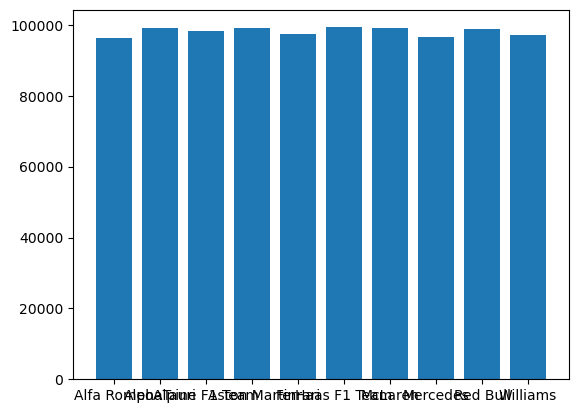